# HKIMR WP

Date: September 25, 2023  
Last run: October 23, 2023_TheFinalists \
Last modified: Quach Toan Long  

Employing a LSTMm approach to measure the shock responses between GSIBs and Crypto. \
In this draft: 
- Data of each row is close file of US, EU, and Crypto in time T and Asia bank in time T+1.

# Set up 

## Library

In [1]:
# matplotlib version: 3.5.2
# pandas version: 1.4.4
# numpy version: 1.21.5
# torch version: 1.8.0+cu111
# scikit-learn version: 1.0.2 (sklearn)
# statsmodels version: 0.13.2
# scipy version: 1.9.1

# Load pandas and torch
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

import torch #Version 1.8.0+cu111
from torch import nn
from torch import tensor
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit  # time series split

# Import helpful_scripts
import helpful_scripts
from helpful_scripts import timestep_gen, pairwise_timestep_gen, timeSeriesCV, train_test, constructDataLoader,dataset_scaler, group2one_timestep_gen

# Import statmodels for VAR
import statsmodels.tsa as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


# Import summary stats
from scipy.stats import skew, kurtosis


# Activate GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data: VAGSIBs

### Load and create data

Load the daily dataset from the CSV file.

HKIMR_2023-09-21.csv contains **daily log return** of BTC, ETH, and 29 GSIBs.

Asia GSIBs is leading. Every row has EU/US/Coin at time t, and data of Asia bank at t+1.

``` 
From R
    #Agricultural Bank of China Limited
    `1288 HK EQUITY` = lead(`1288 HK EQUITY`,1),
    #Bank of China
    `3988 HK EQUITY` = lead(`3988 HK EQUITY`,1),
    #Industrial & Commercial Bank of China
    `601398 CH EQUITY` = lead(`601398 CH EQUITY`,1),
    # Mitsubishi UFJ Financial Group Inc
    `8306 JP EQUITY` = lead(`8306 JP EQUITY`,1),
    # Sumitomo Mitsui Financial Group, Inc.
    `8316 JP EQUITY` = lead(`8316 JP EQUITY`,1))   
    # Mizuho Financial Group
    `8411 JP EQUITY` = lead(`8411 JP EQUITY`,1),
    # China Construction Bank
    `939 HK EQUITY` = lead(`939 HK EQUITY`,1),
```

In [2]:
# Read the data file
dataFile = 'Input/HKIMR_2023-10-21.csv'
VAGSIB = pd.read_csv(dataFile)

data = VAGSIB.iloc[1:,2:] #REmove the first NA lines, then only get non-Dates cols

In [3]:
summary = pd.DataFrame()

summary['mean'] = data.mean()
summary['min'] = data.min()
summary['max'] = data.max()
summary['stddev'] = data.std()
summary['skewness'] = data.apply(skew)
summary['kurtosis'] = data.apply(kurtosis)

summary

,mean,min,max,stddev,skewness,kurtosis
BTC.return,0.002473,-0.433714,0.287099,0.044544,-0.651949,8.805809
ETH.return,0.003479,-0.563080,0.407333,0.067280,-0.013103,7.925302
JPM US EQUITY,0.000466,-0.162106,0.165620,0.017287,-0.049894,13.993056
BAC US EQUITY,0.000317,-0.167205,0.163786,0.019873,-0.046564,9.915644
C US EQUITY,0.000021,-0.214414,0.165381,0.021009,-0.481438,14.567569
HSBA LN EQUITY,-0.000051,-0.105986,0.100812,0.016767,-0.252211,5.222880
3988 HK EQUITY,-0.000117,-0.109023,0.071329,0.012660,-0.611733,7.282827
BARC LN EQUITY,-0.000281,-0.268219,0.146263,0.024248,-1.138345,15.710790
BNP FP EQUITY,0.000027,-0.207774,0.160119,0.021186,-0.720846,10.057129
DBK GR EQUITY,-0.000286,-0.189618,0.131528,0.025304,-0.248828,4.944266


### Create a referencing df

This Map_name will be used later to map variable names to index 

In [4]:
Mapname = {'index': range(len(data.columns)), 'Variable Name': data.columns}
Map_name = pd.DataFrame(Mapname)

#Only keep the Country Code
Map_name['Variable Name'] = Map_name['Variable Name'].str.removeprefix('MX')
Map_name['Variable Name'] = Map_name['Variable Name'].str.removesuffix('0FN Index')

Map_date = VAGSIB.reset_index().loc[1:,['index','Dates']]
Map_date = Map_date.rename(columns={"index": "Date Index"})



# LSTMm Estimates

## Set up parameter values and data ##

**Define parameters**

In [5]:
# USER DEFINED PARAMETERS ----
# model parameters
nvar = data.shape[1]    # number of variables

# LSTM parameters
n_features = nvar
output_size = 1   # output will be 1 x n_features - forecasting only lagp+1

# LSTM parameters - hyperparameters, for fine-tuning

# Training and optimizer parameters
num_epochs = 1500 # change as needed
learn_rate = 0.0001 # value of 0.0001 works well with minmax scaler; 0.001 for standard
L2_regularizer = learn_rate / 10

# Number of splits for cross-validation
n_splits = 5


## LSTM class
__Define class, initialize model_

The LSTM class is constructed below. The only input in the forward function is the input sequence, which would be equal to the batch input. Notice that the `lstm_out` dimensions are reduced to a 2D matrix since the batch input consists of 2D matrices. 

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, h= None):
        lstm_out, h = self.lstm(input_seq,h)
        # Reduce dimensions of baches lstm_out[:,-1,:] 
        
        if input_seq.shape[1] == 1:
            lstm_out = lstm_out
            predictions = self.linear(lstm_out).unsqueeze(1) #Make it 3D 
        else:
            lstm_out = lstm_out[:,-1,:]
            predictions = self.linear(lstm_out).unsqueeze(1) #Make it 3D 

        return predictions, h
    
    def reset_parameters(self):
        self.lstm.reset_parameters()
        

# Define loss and optimizer
criterion = nn.MSELoss()
        

## Cross validation, training and testing

As we are dealing with time series, we use time series cross validation as implemented in scikit-learn. Under the assumption that only the information in the previous lagged observations matter, standard K-fold cross validation could be performed. Details [here](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold).



Keep one fourth of the observations for testing, and save features and labels as `X_test` and `y_test`. The other three fourths of the observations, saved as `x_cv` and `y_cv`, are used for training and validation.

### CV Status

In [7]:
CV = False

### Perform CV loop

This section performs model selection using Time Series Split cross validation routines developed above. The user needs to input the following hyperparameters arrays.



__Define weights__


In [8]:
def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)


__Hyperparameters user input__


In [9]:
# Hyperparameter selection input
lagp_array = [20]
hidden_size_array = [nvar*1, nvar*2,nvar*3,nvar*4,nvar*5] # ,nvar*6,nvar*7,nvar*8,nvar*9,nvar*10]   # number of nodes 
num_layers_array = [1,2,3] # ,4,5]     # one layer might lead to over/under fitting
drop_out_array   = [0.30,0.4,0.5]# ,0.6]   # drop output of some hidden units to avoid overfitting
# num_epochs = 2000

__Model selection loop__  

Because the lag number is also a parameter, the train/test partition codes are moved here.

In each of loops, We keep one fourth of the observations for testing, and save features and labels as `X_test` and `y_test`. The other three fourths of the observations, saved as `x_cv` and `y_cv`, are used for training and validation.

The model should be initialized and the parameters reset. Dropout rates are unnecessary if a 1-layer LSTM is used. The CV loop below takes care of this issue.


In [10]:
if CV:

    cv_loss = list()

    # function skip to skip drop_out iterations when layer ==1

    for lag_num in lagp_array:
        XX, YY = timestep_gen(data.values, lag_num,  1, overlapping= True )
        XX, YY = torch.tensor(np.array(XX)), torch.tensor(np.array(YY))

        last_obs = round(XX.shape[0]*0.75)
        X_cv = XX[:last_obs,:,:].float()
        y_cv = YY[:last_obs,:,:].float()
        X_test = XX[last_obs:,:,:].float()
        y_test = YY[last_obs:,:,:].float()

        test_size = round(y_cv.shape[0]*(1/n_splits))
        max_train_size = round(y_cv.shape[0]*(1-1/n_splits))
        tscv = TimeSeriesSplit()
        # Note that we are using test_size rather than validation_size to be consistent with the
        # notation TimeSeriesSplit uses
        
        TimeSeriesSplit(gap=0, max_train_size = None, 
                        n_splits = n_splits, test_size = test_size)
        
        cv_splits = list(tscv.split(X_cv))

        for hidden_size in hidden_size_array:
            for num_layers in num_layers_array:
                if num_layers == 1:
                    # set the dropout = 0 regardless of the hyperloop value
                    drop_out = 0
                    model = LSTM(input_size=n_features, hidden_size= hidden_size, 
                                 output_size=n_features, num_layers = num_layers, 
                                 dropout = drop_out)           
                    print('=============================================')            
                    print(f'hidden size: {hidden_size}, num_layers: {num_layers}, dropout: {drop_out}')
                    print('=============================================')
                    model.reset_parameters()
                    model.apply(init_weights)            
                    model.to(device)
                    test_loss = timeSeriesCV(cv_splits, X_cv, y_cv,  num_epochs, device,  criterion, model, learn_rate)       
                    cv_loss.append([lag_num, hidden_size, num_layers, drop_out, test_loss])            
                else:
                    for drop_out in drop_out_array:  
                        model = LSTM(input_size=n_features, hidden_size= hidden_size, 
                                 output_size=n_features, num_layers = num_layers, 
                                 dropout = drop_out)            
                        print('=============================================')            
                        print(f'hidden size: {hidden_size}, num_layers: {num_layers}, dropout: {drop_out}')
                        print('=============================================')
                        model.reset_parameters()
                        model.apply(init_weights)            
                        model.to(device)
                        test_loss = timeSeriesCV(cv_splits, X_cv, y_cv,  num_epochs, device,  criterion, model, learn_rate)       
                        cv_loss.append([lag_num, hidden_size, num_layers, drop_out, test_loss])            

    # Recall number of total hypotheses
    cases = len(lagp_array)* len(hidden_size_array)*len(num_layers_array)*len(drop_out_array)
    if 1 in num_layers_array:
        cases = len(lagp_array)*len(hidden_size_array)*((len(num_layers_array)-1)*(len(drop_out_array))+1)

    cv_loss = np.concatenate(cv_loss, axis=0).reshape(cases,5)
    bestPar_idx = np.argmin(cv_loss[:,-1])
    lag_num, hidden_size, num_layers, drop_out, _ = cv_loss[bestPar_idx,:]
    lag_num= lag_num.astype(int)
    hidden_size = hidden_size.astype(int)
    num_layers =  num_layers.astype(int)
    print(f'Model selection')
    print(f'lag_number: {lag_num},hidden_size: {hidden_size}, num_layers: {num_layers}, drop_out: {drop_out}')
    
# I have manually saved the best perform cross-validation group here:    
else: 
    lag_num = 20
    hidden_size=  31
    num_layers= 1
    drop_out= 0.0


Saved CV_loss file as csv for reference.

In [ ]:
# pd.DataFrame(cv_loss).to_csv("cv_loss.csv")

# Model deployment and constructing LSTMm

## Set Seed

In [11]:
# set seed to replicate results
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

seed = 1984

def setup_seed(seed):
    np.random.seed(seed)                          
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True
    # torch.config.experimental.enable_op_determinism() 
    
setup_seed(seed)

## Build a model based on the best parameter

Pick the best parameter set and re-estimate the model. Only the training loop over the epochs is needed. 

In [14]:
XX, YY = timestep_gen(data.values, lag_num,  1, overlapping= True )
XX, YY = torch.tensor(np.array(XX)), torch.tensor(np.array(YY))


torch.Size([2263, 1, 31])

In [32]:
XX, YY = timestep_gen(data.values, range(data.shape[1]),lag_num,  1, overlapping= True )
XX, YY = torch.tensor(np.array(XX)), torch.tensor(np.array(YY))

selected_XX = XX
selected_YY = YY

features = XX.float()
labels = YY.float()
dataset = TensorDataset(features, labels)
batch_size = 4
model_data = DataLoader(dataset, batch_size = batch_size, shuffle = True)

model_20 = LSTM(input_size=n_features, hidden_size= hidden_size, 
             output_size=n_features, #Adjust the output size
             num_layers = num_layers, 
             dropout = drop_out)

model_20.reset_parameters()
model_20.apply(init_weights) 
model_20.to(device)

# Only training required
optimizer = torch.optim.Adam(model_20.parameters(), lr=learn_rate)                           
epoch_train_loss = []
for epoch in range(num_epochs):
    train_losses = []
    for seq_batch, labels_batch in model_data:
        seq_batch = seq_batch.to(device)
        labels_batch = labels_batch.to(device)
        y_pred, _ = model_20(seq_batch)
        # labels_batch = labels_batch.squeeze(1)  # to accommodate batches
        
        loss = criterion(y_pred, labels_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        train_losses.append(loss.item())        
    train_loss = sum(train_losses)/len(train_losses)
    epoch_train_loss.append(train_loss)
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}')


Epoch 1/1500 | Train Loss: 0.0035
Epoch 101/1500 | Train Loss: 0.0005
Epoch 201/1500 | Train Loss: 0.0005
Epoch 301/1500 | Train Loss: 0.0005
Epoch 401/1500 | Train Loss: 0.0005
Epoch 501/1500 | Train Loss: 0.0005
Epoch 601/1500 | Train Loss: 0.0005
Epoch 701/1500 | Train Loss: 0.0005
Epoch 801/1500 | Train Loss: 0.0005
Epoch 901/1500 | Train Loss: 0.0004
Epoch 1001/1500 | Train Loss: 0.0004
Epoch 1101/1500 | Train Loss: 0.0004
Epoch 1201/1500 | Train Loss: 0.0004
Epoch 1301/1500 | Train Loss: 0.0004
Epoch 1401/1500 | Train Loss: 0.0004


In [14]:
torch.save(model_20.state_dict(), "./Input/Leading_Model_20_timestep_Oct22.pt")


## Calculate shock magnitude for each variable

In [34]:
def calculate_error_std_dev(LSTM_model, XX,YY):
    LSTM_model.eval()  # Set the model to evaluation mode
    LSTM_model.to('cpu')

    with torch.no_grad():  
        outputs, _ = LSTM_model(XX.float())
        error = outputs - YY.float()  # Calculate error term
        error = np.concatenate(error.numpy(), axis=0) # Concatenate all error terms into a single numpy array

    std_devs = np.std(error, axis=0)  # Calculate standard deviation of error terms for each column
    return std_devs

In [35]:
shock_array = calculate_error_std_dev(model_20,XX,YY)


## One-percent of Error Standard Deviation shock

Delta: `Delta_x = 0.01 * StDDevError_x` \
Shock calculation: `shock = baseline + Delta_x ` \
LSTMm calculation: `LSTMm = y_shock - y_baseline`

### Impose a percentage shock and calculate LSTMm

In [36]:
XX.shape,data.shape, dshock.shape

NameError: name 'dshock' is not defined

In [37]:
#Initialize empty array

single_res = []
aggregated_res = []
step_res = []

#Calculate the effect after 20 observations
ahead_range = 20

for var_idx in range(XX.shape[2]):
# for var_idx in range(1):

    #Size of the shock
    print("working on "+str(var_idx))
    dshock = shock_array[var_idx]*0.01
    # dshock= 0.01

    x = XX.float().to(torch.device('cuda'))
    xshock = x.clone().detach().to(torch.device('cuda'))

    lag_shock = -1
    model_20.to(torch.device('cuda'))  # move the model to the GPU

    # Add a one percentage point shock in the same direction as the observed return
    xshock[:, lag_shock, var_idx] = torch.Tensor(xshock[:, lag_shock, var_idx].cpu().numpy() + abs(dshock))
    xshock = xshock.to(torch.device('cuda'))
    
    predshock_updated = xshock.clone().detach().to(torch.device('cuda'))
    pred_updated = x.clone().detach().to(torch.device('cuda'))

    xshock_updated = xshock.clone().detach().to(torch.device('cuda'))
    xpred_updated = x.clone().detach().to(torch.device('cuda'))

    model_20.eval()
    
    #Initialize hidden state and cell state manually, to be sure:
    hs_t = torch.zeros(model_20.num_layers, x.size(0), model_20.hidden_size).to(torch.device('cuda'))
    cs_t = torch.zeros(model_20.num_layers, x.size(0), model_20.hidden_size).to(torch.device('cuda'))
    
    hb_t = torch.zeros(model_20.num_layers, x.size(0), model_20.hidden_size).to(torch.device('cuda'))
    cb_t = torch.zeros(model_20.num_layers, x.size(0), model_20.hidden_size).to(torch.device('cuda'))


    for ahead_idx in range(ahead_range):
        with torch.no_grad():

            yshock, (_) = model_20(xshock_updated.to(torch.device('cuda')))
            ypred, (_) = model_20(xpred_updated.to(torch.device('cuda')))

            # Store an expanding windows to measure cumulative changes
            predshock_updated = torch.cat((predshock_updated, yshock), dim=1).to(torch.device('cuda'))
            pred_updated = torch.cat((pred_updated, ypred), dim=1).to(torch.device('cuda'))

            # Append the predicted values into xshock and xpred
            xshock_updated = torch.cat((xshock_updated, yshock), dim=1).to(torch.device('cuda'))
            xpred_updated = torch.cat((xpred_updated, ypred), dim=1).to(torch.device('cuda'))

            # Ignore the first sequence to ensure moving windows
            xshock_updated = xshock_updated[:, 1:, :]
            xpred_updated = xpred_updated[:, 1:, :]

    agg_closeloop = abs(predshock_updated.cpu().sum(axis=1) - pred_updated.cpu().sum(axis=1)) * 100
    aggregated_res.append([var_idx, agg_closeloop])


# Convert the lists to DataFrames

df_aggregated = []

for item in aggregated_res:
    # Extract the order and dataframe from the item
    order, tensor = item

    # Add a new column to the dataframe with the order value
    tempdata = pd.DataFrame(tensor.numpy())
    tempdata['Variable'] = order

    # Add the dataframe to the list
    df_aggregated.append(tempdata)

df_aggregated_l20 = pd.concat(df_aggregated)

                                               


working on 0
working on 1
working on 2
working on 3
working on 4
working on 5
working on 6
working on 7
working on 8
working on 9
working on 10
working on 11
working on 12
working on 13
working on 14
working on 15
working on 16
working on 17
working on 18
working on 19
working on 20
working on 21
working on 22
working on 23
working on 24
working on 25
working on 26
working on 27
working on 28
working on 29
working on 30


### Export files to the Markdown folder

In [38]:
df_aggregated_l20_sddev = df_aggregated_l20.copy()

df_aggregated_l20_sddev.iloc[:,:31] = df_aggregated_l20_sddev.iloc[:,:31] / (shock_array) 

RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
df_aggregated_l20_sddev = df_aggregated_l20_sddev.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
df_aggregated_l20_sddev = df_aggregated_l20_sddev.drop(['index','Date Index'], axis = 1)

# df_aggregated_l20_sddev.to_csv("./Markdown/Data/df_aggregated_l20_sddev (Wide format).csv",index = False)

#Transform to long format

df_aggregated_l20_sddev = pd.melt(df_aggregated_l20_sddev, id_vars=df_aggregated_l20_sddev.columns[31:], var_name="Target_Variables",
                                value_name = "Value")
df_aggregated_l20_sddev.to_csv("./Data/Leading_Percent_STDDEV_shock.csv",index = False)


### Visualize

#### BTC to ETH

Prepare data: 
+ Select source variable
+ Remove outlier: replace those that higher than 95 percentile with its MA120
+ Calculate MA 
+ Map dates into the dataset

In [39]:
selected_var = 0

df_aggregated_l20_sddev = df_aggregated_l20.copy()
df_aggregated_l20_sddev.iloc[:,:31] = df_aggregated_l20_sddev.iloc[:,:31] / (shock_array) 


Var_name = Map_name['Variable Name'][selected_var]
df2plot = df_aggregated_l20_sddev.loc[df_aggregated_l20_sddev['Variable'] == selected_var,:]

# BTC to ETH
lstmm_MA = df2plot.copy()

# Calculate the 95th percentile
threshold = np.percentile(lstmm_MA.abs().values, 97.5)

lstmm_MAdf = lstmm_MA.applymap(lambda x: threshold if abs(x) >= threshold else x)
lstmm_MAdf = lstmm_MAdf.fillna(lstmm_MAdf.rolling(120, min_periods=1).mean())

# Calculate the number of elements in lstmm_MA
total_elements = lstmm_MA.size
# Calculate the number of elements that have been changed by the filter
changed_elements = (lstmm_MA != lstmm_MAdf).sum().sum()
# Calculate the percentage of elements that have been changed
percentage_changed = (changed_elements / total_elements) * 100

# Set Moving Average window
MVA = 120
lstmm_MAdf = lstmm_MAdf.rolling(window=MVA).mean()
lstmm_MAdf.iloc[:,:31].columns = Map_name['Variable Name']

# Map dates into the df
RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
lstmm_MAdf = lstmm_MAdf.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
lstmm_MAdf = lstmm_MAdf.drop(['index','Date Index'], axis = 1)

**Plot the data**

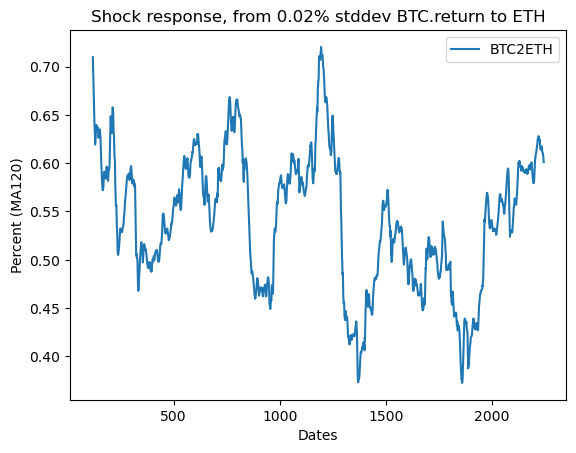

In [40]:

lstmm_MAdf.iloc[:,1].plot(label = "BTC2ETH")

# Add labels and title
plt.xlabel('Dates')
plt.ylabel('Percent (MA'+str(MVA)+')')
plt.title(f"Shock response, from {dshock*100:.2f}% stddev {Var_name} to ETH")

# txt=(f"The filter affected {percentage_changed:.2f}% of lstmm_MA")
# plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

# Show the plot
plt.show()


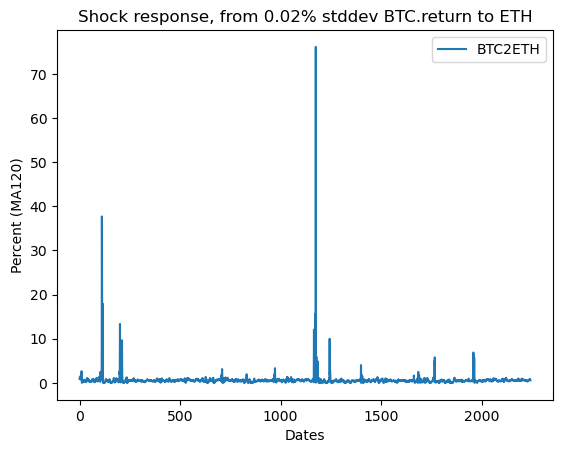

In [41]:
selected_var = 0

df_aggregated_l20_sddev = df_aggregated_l20.copy()
df_aggregated_l20_sddev.iloc[:,:31] = df_aggregated_l20_sddev.iloc[:,:31] / (shock_array) 


Var_name = Map_name['Variable Name'][selected_var]
df2plot = df_aggregated_l20_sddev.loc[df_aggregated_l20_sddev['Variable'] == selected_var,:]

# BTC to ETH
lstmm_MAdf = df2plot.copy()

# # Calculate the 95th percentile
# threshold = np.percentile(lstmm_MA.abs().values, 95)

# lstmm_MAdf = lstmm_MA.applymap(lambda x: threshold if abs(x) >= threshold else x)
# lstmm_MAdf = lstmm_MAdf.fillna(lstmm_MAdf.rolling(120, min_periods=1).mean())

# # Calculate the number of elements in lstmm_MA
# total_elements = lstmm_MA.size
# # Calculate the number of elements that have been changed by the filter
# changed_elements = (lstmm_MA != lstmm_MAdf).sum().sum()
# # Calculate the percentage of elements that have been changed
# percentage_changed = (changed_elements / total_elements) * 100

# # Set Moving Average window
# MVA = 120
# lstmm_MAdf = lstmm_MAdf.rolling(window=MVA).mean()
lstmm_MAdf.iloc[:,:31].columns = Map_name['Variable Name']

# Map dates into the df
RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
lstmm_MAdf = lstmm_MAdf.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
lstmm_MAdf = lstmm_MAdf.drop(['index','Date Index'], axis = 1)


lstmm_MAdf.iloc[:,1].plot(label = "BTC2ETH")

# Add labels and title
plt.xlabel('Dates')
plt.ylabel('Percent (MA'+str(MVA)+')')
plt.title(f"Shock response, from {dshock*100:.2f}% stddev {Var_name} to ETH")

# txt=(f"The filter affected {percentage_changed:.2f}% of lstmm_MA")
# plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

# Show the plot
plt.show()


#### BTC to GSIBs

Prepare data: 
+ Select source variable
+ Remove outlier: replace those that higher than 95 percentile with its MA120
+ Calculate MA 
+ Map dates into the dataset

In [42]:
selected_var = 0
Var_name = Map_name['Variable Name'][selected_var]

df2plot = df_aggregated_l20_sddev.loc[df_aggregated_l20_sddev['Variable'] == selected_var,:]

# BTC to ETH
lstmm_MA = df2plot.copy()

# Calculate the 95th percentile
threshold = np.percentile(lstmm_MA.abs().values, 97.5)

lstmm_MAdf = lstmm_MA.applymap(lambda x: threshold if abs(x) >= threshold else x)
lstmm_MAdf = lstmm_MAdf.fillna(lstmm_MAdf.rolling(120, min_periods=1).mean())

# Calculate the number of elements in lstmm_MA
total_elements = lstmm_MA.size
# Calculate the number of elements that have been changed by the filter
changed_elements = (lstmm_MA != lstmm_MAdf).sum().sum()
# Calculate the percentage of elements that have been changed
percentage_changed = (changed_elements / total_elements) * 100

# Set Moving Average window
MVA = 120
lstmm_MAdf = lstmm_MAdf.rolling(window=MVA).mean()
lstmm_MAdf.iloc[:,:31].columns = Map_name['Variable Name']

# Map dates into the df
RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
lstmm_MAdf = lstmm_MAdf.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
lstmm_MAdf = lstmm_MAdf.drop(['index','Date Index'], axis = 1)

**Plot the data**

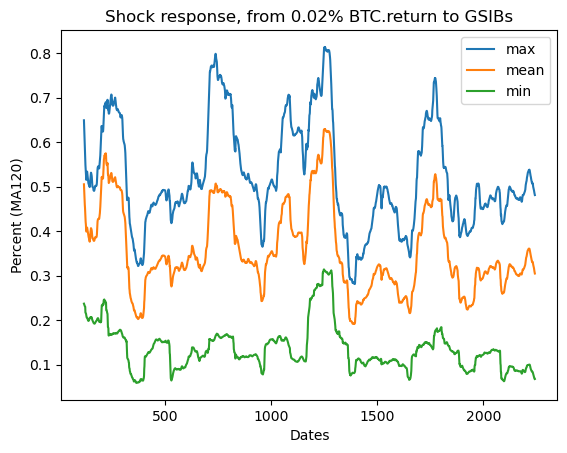

In [43]:

lstmm_MAdf.iloc[:,2:31].max(axis=1).plot(label = "max")
lstmm_MAdf.iloc[:,2:31].mean(axis=1).plot(label = "mean")
lstmm_MAdf.iloc[:,2:31].min(axis=1).plot(label = "min")

# Add labels and title
plt.xlabel('Dates')
plt.ylabel('Percent (MA'+str(MVA)+')')
plt.title(f"Shock response, from {dshock*100:.2f}% {Var_name} to GSIBs")

# txt=(f"The filter affected {percentage_changed:.2f}% of lstmm_MA")
# plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

# Show the plot
plt.show()


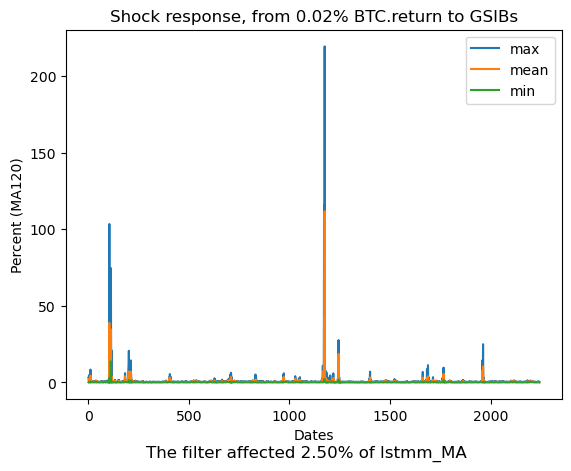

In [45]:
selected_var = 0
Var_name = Map_name['Variable Name'][selected_var]

df2plot = df_aggregated_l20_sddev.loc[df_aggregated_l20_sddev['Variable'] == selected_var,:]

# BTC to ETH
lstmm_MAdf = df2plot.copy()

# Calculate the 95th percentile
# threshold = np.percentile(lstmm_MA.abs().values, 97.5)

# lstmm_MAdf = lstmm_MA.applymap(lambda x: threshold if abs(x) >= threshold else x)
# # lstmm_MAdf = lstmm_MAdf.fillna(lstmm_MAdf.rolling(120, min_periods=1).mean())

# # Calculate the number of elements in lstmm_MA
# total_elements = lstmm_MA.size
# # Calculate the number of elements that have been changed by the filter
# changed_elements = (lstmm_MA != lstmm_MAdf).sum().sum()
# # Calculate the percentage of elements that have been changed
# percentage_changed = (changed_elements / total_elements) * 100

# Set Moving Average window
# MVA = 120
# lstmm_MAdf = lstmm_MAdf.rolling(window=MVA).mean()
lstmm_MAdf.iloc[:,:31].columns = Map_name['Variable Name']

# Map dates into the df
RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
lstmm_MAdf = lstmm_MAdf.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
lstmm_MAdf = lstmm_MAdf.drop(['index','Date Index'], axis = 1)


lstmm_MAdf.iloc[:,2:31].max(axis=1).plot(label = "max")
lstmm_MAdf.iloc[:,2:31].mean(axis=1).plot(label = "mean")
lstmm_MAdf.iloc[:,2:31].min(axis=1).plot(label = "min")

# Add labels and title
plt.xlabel('Dates')
plt.ylabel('Percent (MA'+str(MVA)+')')
plt.title(f"Shock response, from {dshock*100:.2f}% {Var_name} to GSIBs")

txt=(f"The filter affected {percentage_changed:.2f}% of lstmm_MA")
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

# Show the plot
plt.show()


#### ETH to GSIBs

Prepare data: 
+ Select source variable
+ Remove outlier: replace those that higher than 95 percentile with its MA120
+ Calculate MA 
+ Map dates into the dataset

In [46]:
selected_var = 1
Var_name = Map_name['Variable Name'][selected_var]

df2plot = df_aggregated_l20_sddev.loc[df_aggregated_l20_sddev['Variable'] == selected_var,:]

# BTC to ETH
lstmm_MA = df2plot.copy()

# Calculate the 95th percentile
threshold = np.percentile(lstmm_MA.abs().values, 97.5)

lstmm_MAdf = lstmm_MA.applymap(lambda x: threshold if abs(x) >= threshold else x)
lstmm_MAdf = lstmm_MAdf.fillna(lstmm_MAdf.rolling(120, min_periods=1).mean())

# Calculate the number of elements in lstmm_MA
total_elements = lstmm_MA.size
# Calculate the number of elements that have been changed by the filter
changed_elements = (lstmm_MA != lstmm_MAdf).sum().sum()
# Calculate the percentage of elements that have been changed
percentage_changed = (changed_elements / total_elements) * 100

# Set Moving Average window
MVA = 120
lstmm_MAdf = lstmm_MAdf.rolling(window=MVA).mean()
lstmm_MAdf.iloc[:,:31].columns = Map_name['Variable Name']

# Map dates into the df
RefDate = Map_date.copy()
RefDate['Date Index'] -= lag_num
lstmm_MAdf = lstmm_MAdf.reset_index().merge(RefDate,left_on = "index", right_on="Date Index")
lstmm_MAdf = lstmm_MAdf.drop(['index','Date Index'], axis = 1)

**Plot the data**

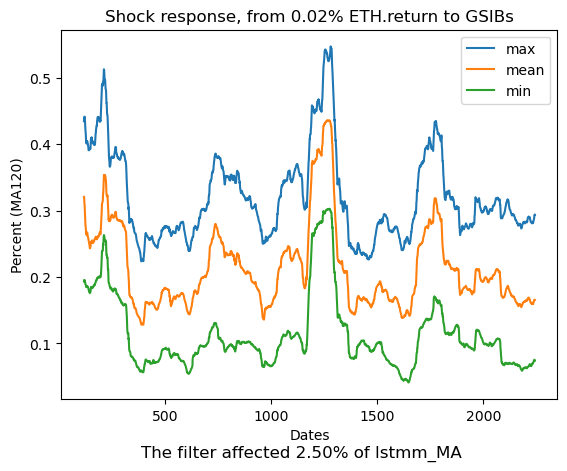

In [47]:

lstmm_MAdf.iloc[:,2:31].max(axis=1).plot(label = "max")
lstmm_MAdf.iloc[:,2:31].mean(axis=1).plot(label = "mean")
lstmm_MAdf.iloc[:,2:31].min(axis=1).plot(label = "min")

# Add labels and title
plt.xlabel('Dates')
plt.ylabel('Percent (MA'+str(MVA)+')')
plt.title(f"Shock response, from {dshock*100:.2f}% {Var_name} to GSIBs")

txt=(f"The filter affected {percentage_changed:.2f}% of lstmm_MA")
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

# Show the plot
plt.show()
